Primero:
    
    1.Obtner mejores datos y no guardar noralizados
    3.Hacer con sus spead como Y en lugar del rating (sacar bonos a 10Y pasar a monda del rf y restar la yield del rf)
    
Problemas:

    1.tenemos mayoria entorno a BBB el modelo se va siempre a ese entorno
    7 ojo porque estoy pillando tambien gobiernos
Pendientes:
    
    1.una vez tengamos los datos, desnormalizarlos para poder usar los ratios directamente
    5.Explicar todo el código bien.
    6.para el problema de tener pocos datos de una clase, undersampling o oversampling o decir a kaeras que no estan balanciados
    8.meter las betas de las compañias, mayor beta mayor riesgo
    9.elgir las mejores variables que lo expliquen
    10.Ver si con Eikon se puede obetner algo mejor
    10 over y under sampling https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

### Observaciones:

Variables X, independientes: 
    
1) Ratios->Variables númericas, todos los ratios. Luego se verá si existe colinialidad entre ellas y con cuales nos quedamos.
2) Sector->Variables categoricas (también llamadas variables nominales), tiene dos o más categorías pero no tienen un orden intrínsico en las categorías.
    
Variable Y, dependiente:
    
1) Rating->Ordinal, no son numéricas pero tienen un orden.

Veamos cuantos valores tenemos por cada variable dependiente, categórica, ratings. Ya que si tenemos muchos ratings de BBB por ejemplo, nuestro modelo estará sesgado.

*Ordinal data can be encoded one of three ways, broadly speaking, but I think it’s safe to say that its encoding is often not carefully considered.*

*1.It can be assumed to be close enough to interval data — with relatively equal magnitudes between the values — to treat it as such. Social scientists make this assumption all the time with Likert scales. For example, “On a scale from 1 to 7, 1 being extremely unlikely, 4 being neither likely nor unlikely and 7 being extremely likely, how likely are you to recommend this movie to a friend?”. Here the difference between 3 and 4 and the difference between 6 and 7 can be reasonably assumed to be similar.*

*2.It can be treated as nominal data, where each category has no numeric relationship to another. One-hot encoding and other encodings appropriate for nominal data make sense here.*

*3.The magnitude of the difference between the numbers can be ignored. You can just train your model with different encodings and seeing which encoding works best.*

XXXX Este desequilibrio en los datos provoca que el modelo simpre predice entorno a `BBB` por tanto tenemos que multiplicar los datos las otras categorias para poder tener un base de datos mas equilibrada.

In [27]:
"""df_duplicados = pd.DataFrame(df, copy=True)
All_rating_increase_dict = {k:0 for k in All_rating_order}

for rating in All_rating_order:
    All_rating_increase_dict[rating] = len(df_duplicados[df_duplicados.Rating == rating])

max_rating = max(All_rating_increase_dict.values())

for rating, v in All_rating_increase_dict.items():
    if v != 0 and v < 1300:
        numero_de_repeticiones = int(max_rating / v ) 
        All_rating_increase_dict[rating] = numero_de_repeticiones
        print("Duplicaciones:",rating,numero_de_repeticiones)
        for i in range(0,numero_de_repeticiones):
            df_duplicados = pd.concat([df_duplicados,df[df.Rating == rating]])

bar_grafica('Frecuencia y número de observaciones por rating con oversampling',
            All_rating_order,
            df_duplicados)"""

'df_duplicados = pd.DataFrame(df, copy=True)\nAll_rating_increase_dict = {k:0 for k in All_rating_order}\n\nfor rating in All_rating_order:\n    All_rating_increase_dict[rating] = len(df_duplicados[df_duplicados.Rating == rating])\n\nmax_rating = max(All_rating_increase_dict.values())\n\nfor rating, v in All_rating_increase_dict.items():\n    if v != 0 and v < 1300:\n        numero_de_repeticiones = int(max_rating / v ) \n        All_rating_increase_dict[rating] = numero_de_repeticiones\n        print("Duplicaciones:",rating,numero_de_repeticiones)\n        for i in range(0,numero_de_repeticiones):\n            df_duplicados = pd.concat([df_duplicados,df[df.Rating == rating]])\n\nbar_grafica(\'Frecuencia y número de observaciones por rating con oversampling\',\n            All_rating_order,\n            df_duplicados)'

En caso de querer trabajar con los datos dupliocamos ejecutamos el codigo siguiente:

In [28]:
#df = df_duplicados

# Analisis previos de los datos

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind, shapiro, levene,anderson, kruskal
from statsmodels.stats.diagnostic import lilliefors

from sklearn.linear_model import SGDClassifier
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.datasets import make_classification
import cufflinks as cf
from functions import *

# ggplot style
plt.style.use('ggplot')

In [30]:
# read the clean data
df = pd.read_csv('all_data_clean.csv')
print(df.shape)
df.head()

(23185, 25)


,Excel Company ID,Rating,Sector,Current Assets,Cash and equivalents,Receivables,Total Assets,Current Liabilities,Long Term Debt,Total Debt,...,Debt to Assets,Long Term Debt to Equity,Financial Leverage,Current Ratio,Quick Ratio,Cash ratio,Debt to Equity,Debt ratio,Rating_group,Net Debt
0,IQ5522615,AAA,Industrials,131.88622,40.31142,79.35595,948.46022,375.10682,140.04878,298.03042,...,0.449078,0.383045,2.594117,0.351596,0.319022,0.107467,0.815138,3.182428,AAA,257.71900
1,IQ4112645,AAA,Industrials,19851.15657,1694.92907,17057.47764,59124.55826,12387.79077,36441.35861,43611.62214,...,0.975040,4.593871,14.886094,1.602478,1.513781,0.136823,5.753375,1.355706,AAA,41916.69307
2,IQ134385765,AAA,Financials,56290.37100,382.95500,53255.75500,187664.38700,125659.11500,58822.43600,159460.40600,...,0.999257,4.593871,14.886094,0.447961,0.426859,0.003048,5.753375,1.176871,AAA,159077.45100
3,IQ12465523,AAA,Industrials,166.71682,10.61747,135.99393,1993.93763,583.17000,232.45475,530.76038,...,0.453090,0.362835,3.112306,0.285880,0.251404,0.018206,0.828456,3.756757,AAA,520.14291
4,IQ139677,AAA,Health Care,40948.66165,15191.95565,8503.05235,96321.22385,18638.76625,9689.25465,13216.64570,...,0.197336,0.180236,1.791730,2.196962,1.271276,0.815073,0.245851,7.287872,AAA,-1975.30995


In [31]:
sum(df['Sector']=='0')
df = df[df['Sector']!='0']

In [32]:
var_x_num = ["Net Debt to EBITDA", "Debt to Assets", "Current Ratio", "Quick Ratio", "Cash ratio", "Long Term Debt to Equity","Debt to Equity", "Debt ratio", "Financial Leverage"]
var_x_cat = ['Sector']
var_x = var_x_num + var_x_cat
all_var_x = ['Excel Company ID'] + var_x
var_y = ['Rating']#,'Rating_group']
df[var_y+all_var_x].head()

,Rating,Excel Company ID,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage,Sector
0,AAA,IQ5522615,1.942794,0.449078,0.351596,0.319022,0.107467,0.383045,0.815138,3.182428,2.594117,Industrials
1,AAA,IQ4112645,15.000000,0.975040,1.602478,1.513781,0.136823,4.593871,5.753375,1.355706,14.886094,Industrials
2,AAA,IQ134385765,15.000000,0.999257,0.447961,0.426859,0.003048,4.593871,5.753375,1.176871,14.886094,Financials
3,AAA,IQ12465523,3.084394,0.453090,0.285880,0.251404,0.018206,0.362835,0.828456,3.756757,3.112306,Industrials
4,AAA,IQ139677,0.000000,0.197336,2.196962,1.271276,0.815073,0.180236,0.245851,7.287872,1.791730,Health Care


Observamos la distribucion de las varaibles por raing 

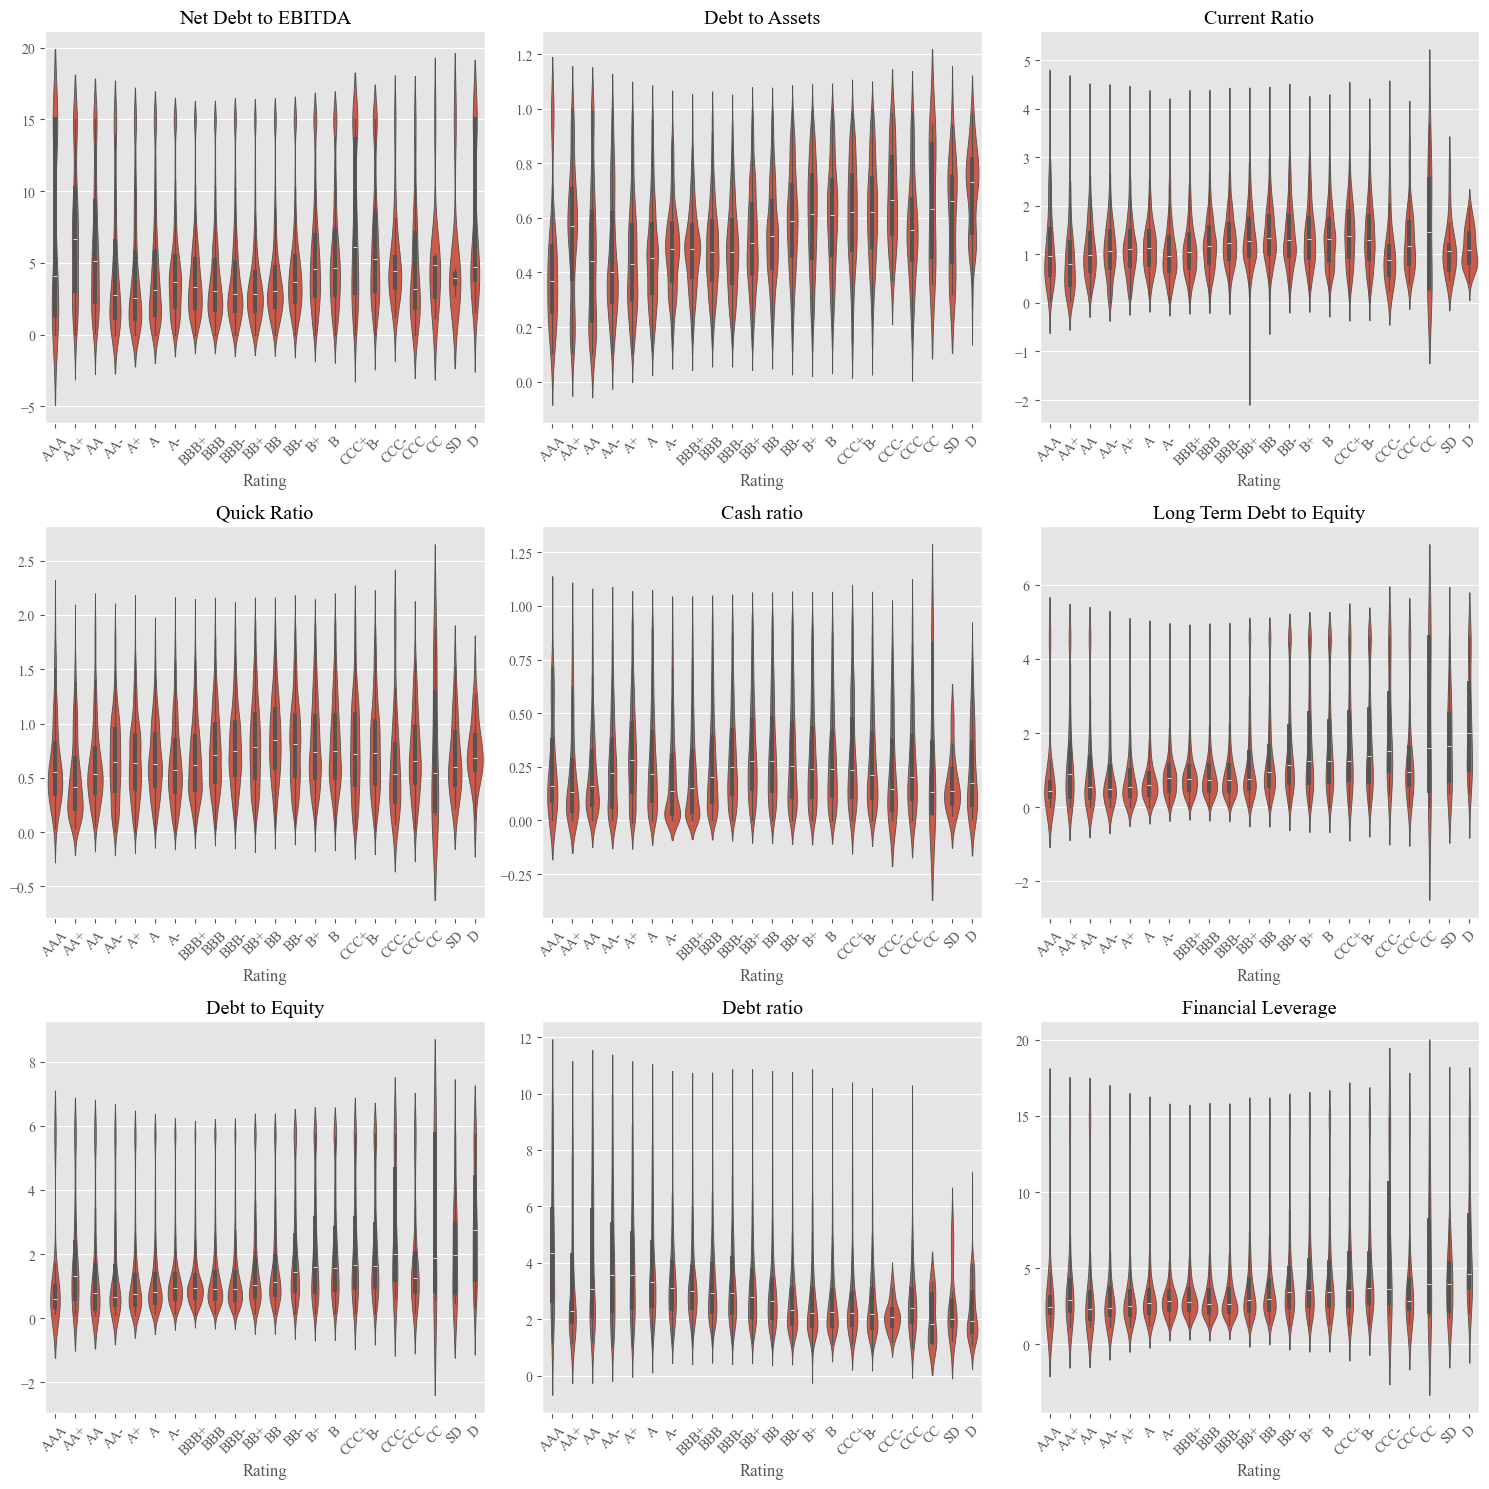

In [33]:
#Gráfico con la distribución de los datos por Rating
fig, axes = plt.subplots(3, 3, figsize=(5*3, 5*3))
# change the font size to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

for i, y in enumerate(var_x_num):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sns.violinplot(x='Rating', y=y, data=df, ax=ax)
    ax.tick_params(axis='x', rotation=45) 
    ax.set_ylabel('')
    ax.set_title(y)

plt.tight_layout()
plt.show()

Obervamos la distribucion de las varaibles por Sector

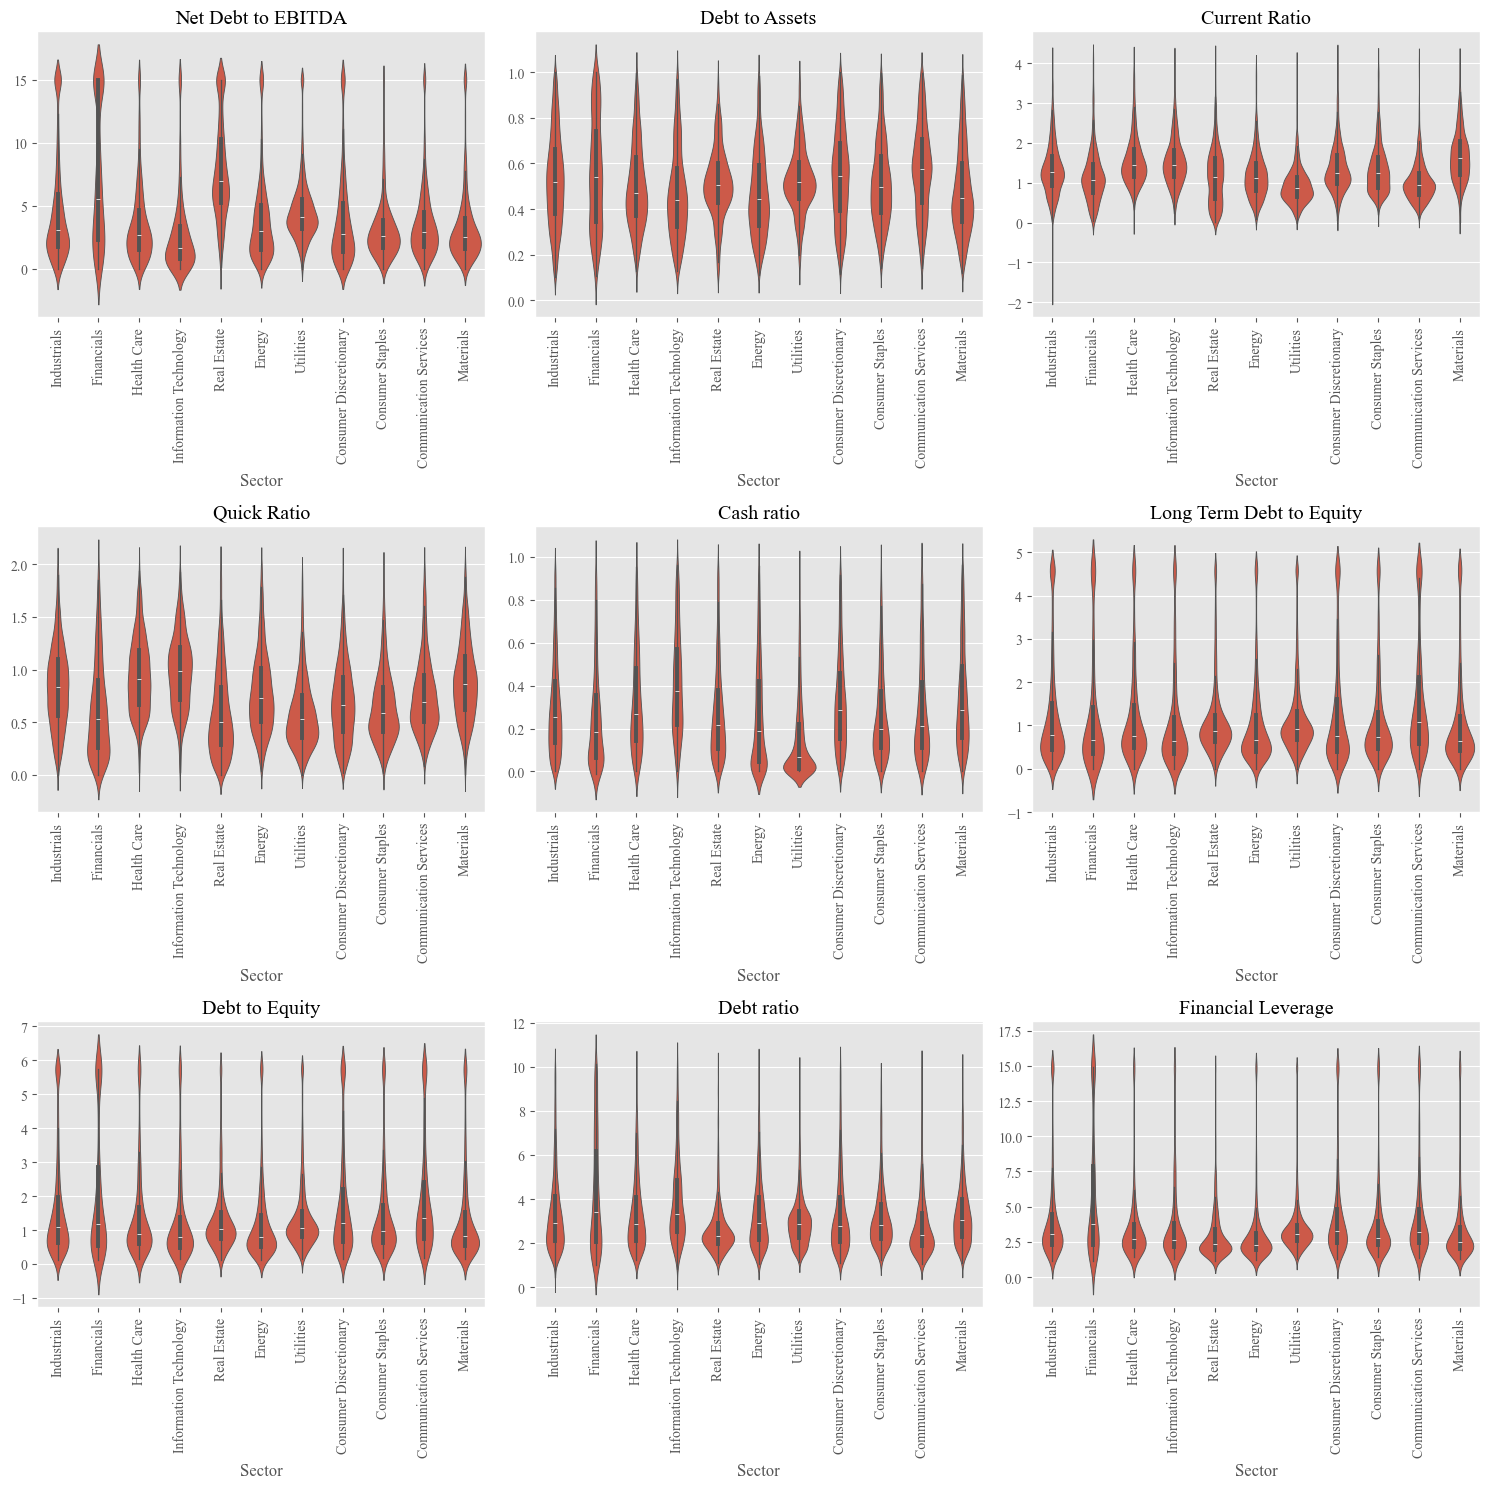

In [34]:
#Gráfico con la distribución de los datos por Sector
fig, axes = plt.subplots(3, 3, figsize=(5*3, 5*3))
# change the font size to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

for i, y in enumerate(var_x_num):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    sns.violinplot(x='Sector', y=y, data=df, ax=ax)
    # Rotate the x-axis labels without setting them explicitly
    ax.tick_params(axis='x', rotation=90) 
    ax.set_ylabel('')
    ax.set_title(y)

plt.tight_layout()
plt.show()

Hacemos una talba de frecuencias de las variables según su rating

In [35]:
df['Financial Leverage'].describe()

count    23183.000000
mean         3.840507
std          2.946880
min          1.129610
25%          2.193579
50%          2.872578
75%          4.040411
max         14.886094
Name: Financial Leverage, dtype: float64

In [36]:
# usamos la funcion cut para definir los intervalos de las variables continuas
df['Financial Leverage_group'] = pd.cut(df['Financial Leverage'], bins=5)

In [53]:
# Crear una tabla de frecuencia bidimensional
table_frecuencia = pd.crosstab(df['Rating_group'], df['Financial Leverage_group'], normalize='index')*100
# round the table to 0 decimal places
table_frecuencia = table_frecuencia.round(0)
# ordenar las filas en este orden 'AAA', 'A', 'A', 'BBB', 'BB', 'BB', 'CCC', 'CCC', 'D',
rating_group_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
table_frecuencia = table_frecuencia.reindex(rating_group_order)
table_frecuencia

Financial Leverage_group,"(1.116, 3.881]","(3.881, 6.632]","(6.632, 9.384]","(9.384, 12.135]","(12.135, 14.886]"
Rating_group,,,,,
AAA,86.0,2.0,0.0,0.0,12.0
AA,76.0,9.0,4.0,1.0,10.0
A,80.0,12.0,3.0,1.0,3.0
BBB,79.0,14.0,3.0,1.0,2.0
BB,67.0,20.0,5.0,2.0,5.0
B,56.0,25.0,7.0,3.0,9.0
CCC,59.0,19.0,6.0,6.0,9.0
CC,50.0,8.0,17.0,17.0,8.0
C,NaN,NaN,NaN,NaN,NaN


- $Net\ Debt\ to\ EBITDA = \frac{Total\ Debt - Cash\ and\ equivalents}{EBITDA}$

- $Debt\ to\ Assets = \frac{Total\ Debt}{Total\ Equity\ +\ Total\ Debt}$
- $Current\ Ratio\ =\ \frac{Current\ Assets}{Current\ Liabilities}$
- $Quick\ Ratio\ =\ \frac{Cash\ and\ equivalents\ +\ Receivables}{Current Liabilities}$
- $Cash\ ratio\ =\ \frac{Cash\ and\ equivalents}{Current Liabilities}$

- $Long\ Term\ Debt\ to\ Equity\ =\ \frac{Long\ Term\ Debt}{Total\ Equity}$
- $Debt\ to\ Equity\ =\ \frac{Total\ Debt}{Total Equity}$
- $Debt\ ratio\ =\ \frac{Total\ Assets}{Tota\l Debt}$
- $Financial\ Leverage\ =\ \frac{Total\ Assets}{Total\ Equity}$

In [38]:
formulas = [r'$Net\ Debt\ to\ EBITDA = \frac{Total\ Debt - Cash\ and\ equivalents}{EBITDA}$',r'$Debt\ to\ Assets = \frac{Total\ Debt}{Total\ Equity\ +\ Total\ Debt}$',r'$Current\ Ratio\ =\ \frac{Current\ Assets}{Current\ Liabilities}$',
r'$Quick\ Ratio\ =\ \frac{Cash\ and\ equivalents\ +\ Receivables}{Current\ Liabilities}$',r'$Cash\ ratio\ =\ \frac{Cash\ and\ equivalents}{Current\ Liabilities}$',r'$Long\ Term\ Debt\ to\ Equity\ =\ \frac{Long\ Term\ Debt}{Total\ Equity}$',
r'$Debt\ to\ Equity\ =\ \frac{Total\ Debt}{Total\ Equity}$',r'$Debt\ ratio\ =\ \frac{Total\ Assets}{Total\ Debt}$',r'$Financial\ Leverage\ =\ \frac{Total\ Assets}{Total\ Equity}$']

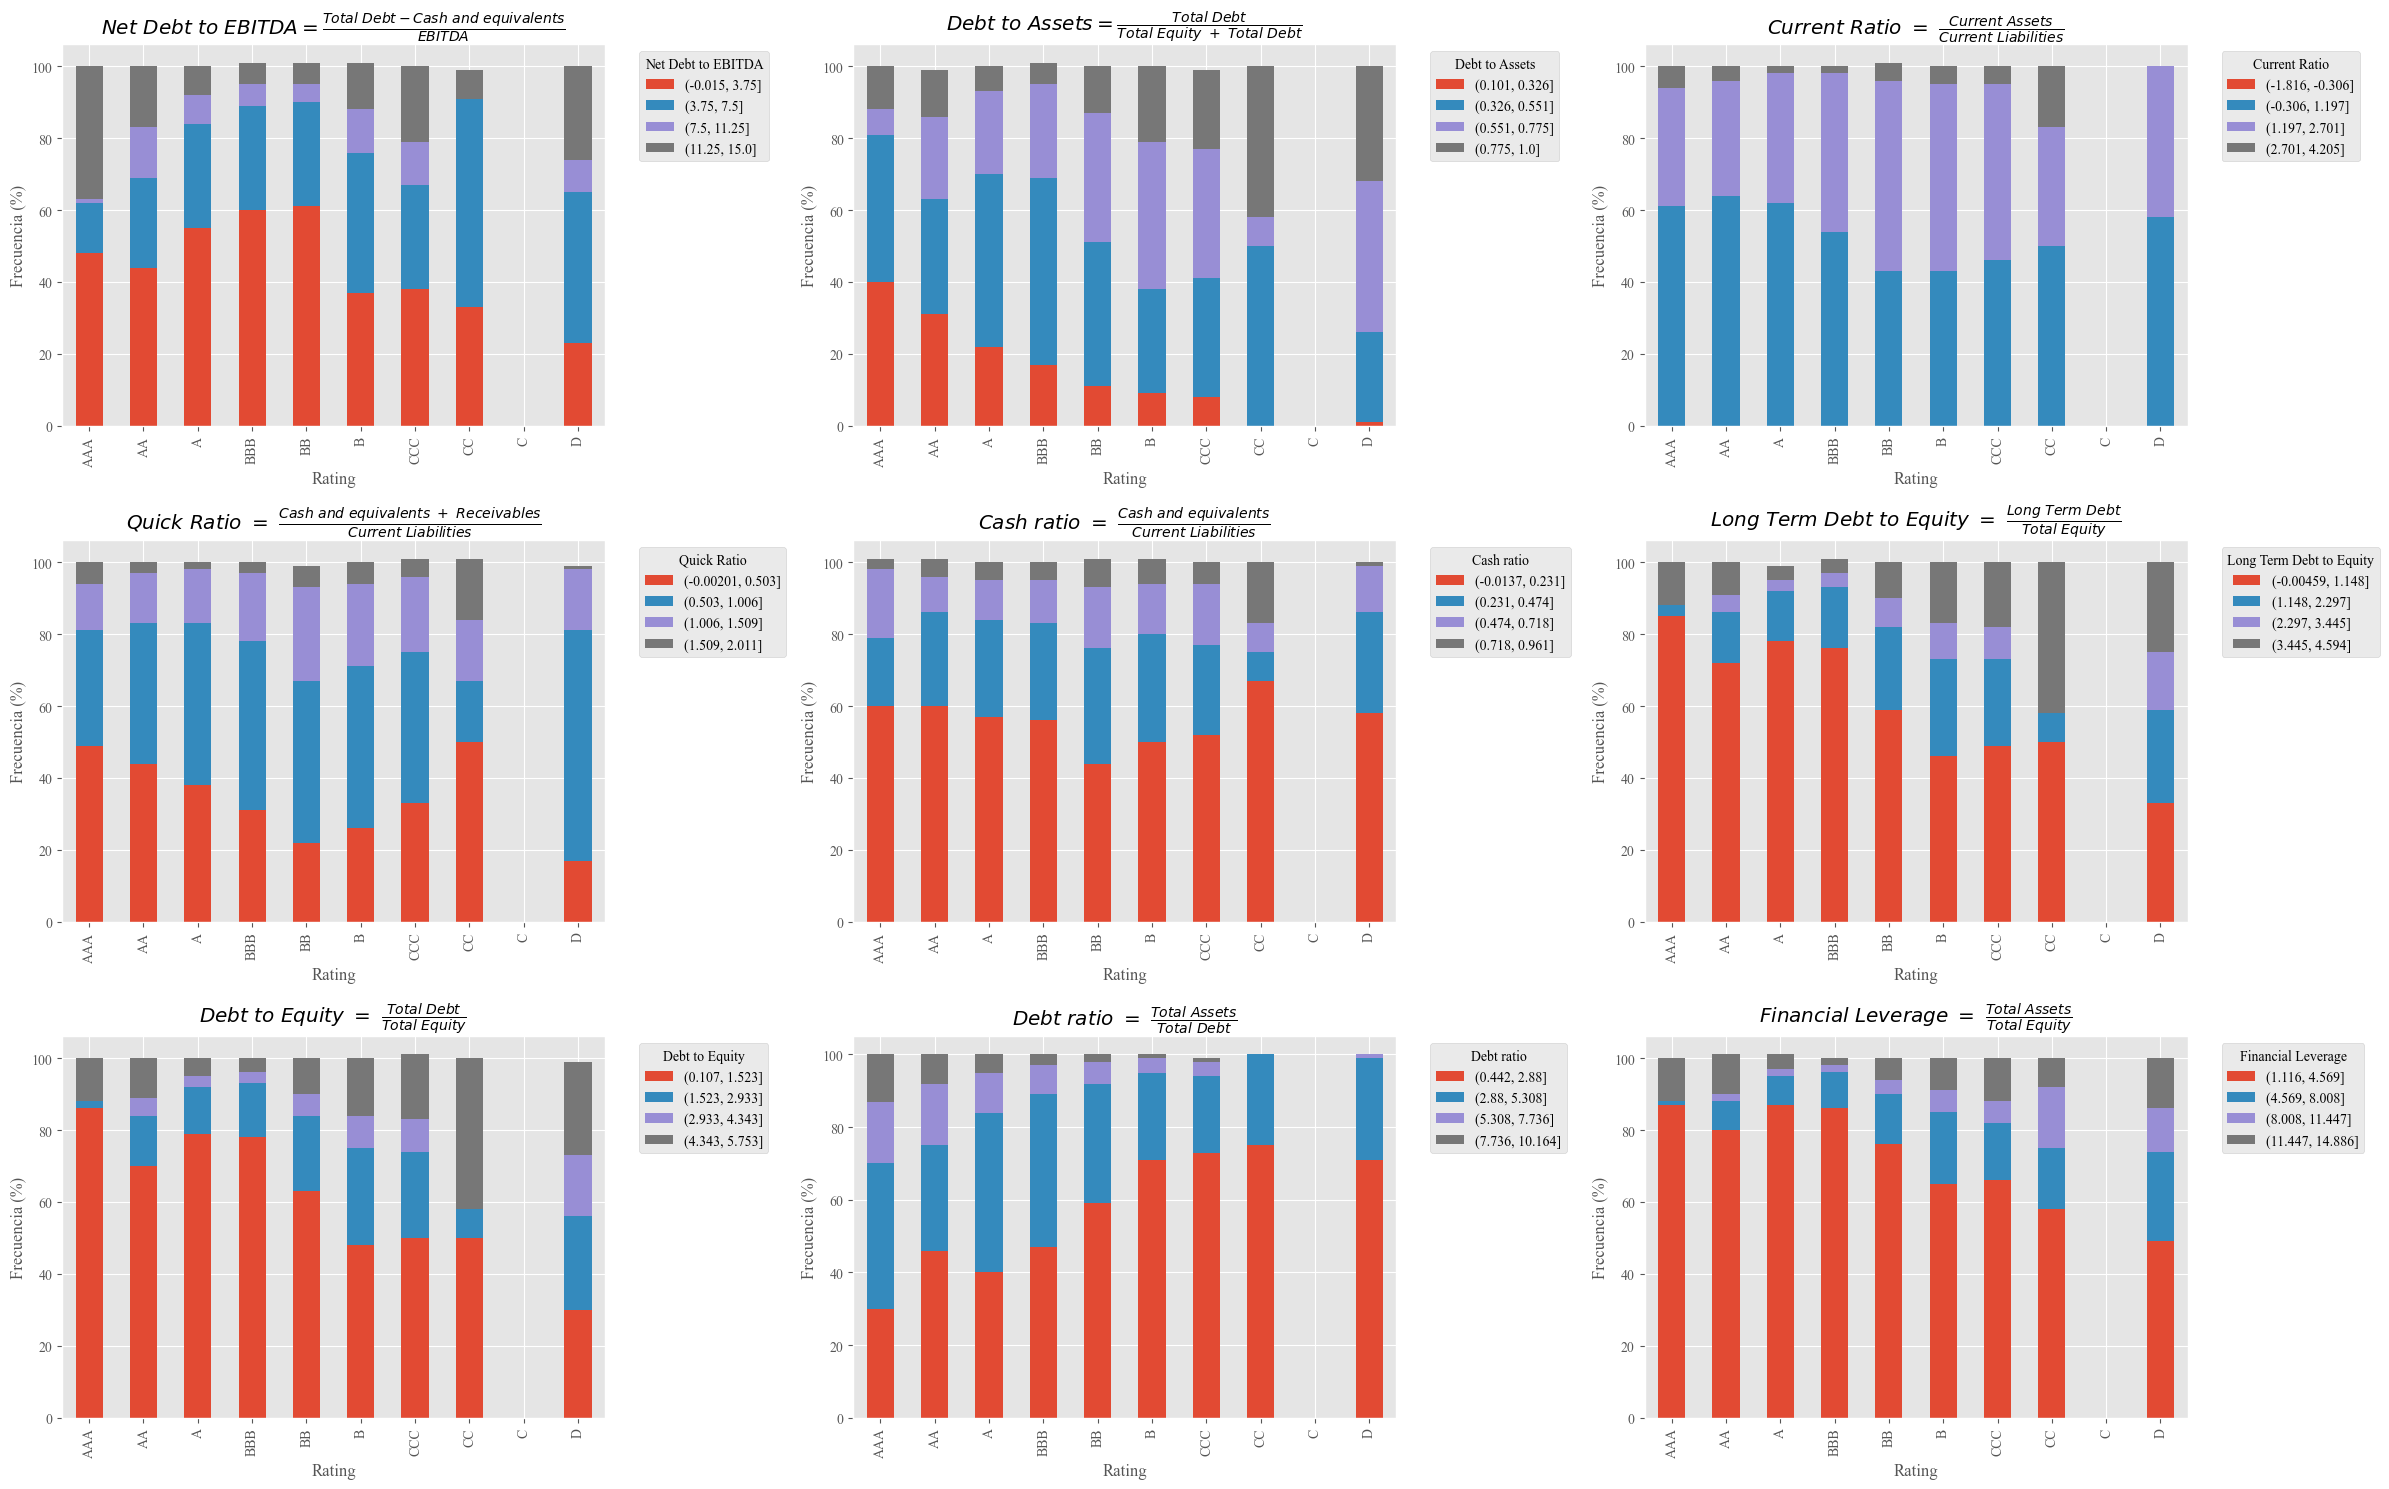

In [39]:
#hacer este grafico para todas las var_x_num en un subplot	

fig, axes = plt.subplots(3, 3, figsize=(8*3, 5*3))
for var,formula in zip(var_x_num,formulas):
    row = var_x_num.index(var) // 3
    col = var_x_num.index(var) % 3
    ax = axes[row, col]
    table_frecuencia = pd.crosstab(df['Rating_group'], pd.cut(df[var], bins=4), normalize='index')*100
    table_frecuencia = table_frecuencia.round(0)
    table_frecuencia = table_frecuencia.reindex(rating_group_order)
    table_frecuencia.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_title('{}'.format(formula))
    ax.set_ylabel('Frecuencia (%)')
    ax.set_xlabel('Rating')
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Análisis estadistico de los datos

In [40]:
df[var_y+var_x_num].describe()

,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
count,23183.000000,23183.000000,23183.000000,23183.000000,23183.000000,23183.000000,23183.000000,23183.000000,23183.000000
mean,4.466823,0.518201,1.265094,0.743553,0.272413,1.195916,1.521466,3.252083,3.840507
std,3.769385,0.187069,0.644012,0.389758,0.230250,1.142892,1.418868,1.656280,2.946880
min,0.000000,0.101420,-1.810261,0.000000,-0.012686,0.000000,0.112867,0.452000,1.129610
25%,1.883149,0.384140,0.815800,0.448677,0.085664,0.466426,0.623746,2.110077,2.193579
50%,3.421204,0.505493,1.168088,0.695380,0.216185,0.811940,1.022218,2.813754,2.872578
75%,5.693014,0.637081,1.600198,0.992845,0.404038,1.394323,1.755433,3.845122,4.040411
max,15.000000,1.000000,4.204907,2.011484,0.961125,4.593871,5.753375,10.164151,14.886094


 Cuando se comparan dos poblaciones mediante muestras aleatorias nuestro objetivo es conocer si los parámetros de interés (medias, proporciones o varianzas) son diferentes en las poblaciones a partir de los resultados obtenidos en las muestras (inferencia).

Para ello realizamos contrastes de hipótesis que consisten en someter a prueba la hipótesis nula H0 (ausencia de diferencias).

Los contrastes habitualmente son bilaterales, con una hipótesis nula H0 del tipo “Parámetro de la población 1 = Parámetro de la población 2” y una hipótesis alternativa H1 del tipo “Parámetro de la población diferente de Parámetro de la población 2”. En ocasiones los contrastes pueden ser unilaterales (solo nos interesa un sentido de la desigualdad).

La probabilidad de que una diferencia observada entre 2 parámetros (medias, proporciones o varianzas) se deba realmente al azar se denomina grado de significación P. Cuando rechazamos una hipótesis nula podemosequivocarnos, ese error denominado error de primera especie o error a debe ser menor del 5%. Por tanto, solo aceptaremos una diferencia como significativa cuando la probabilidad de que se deba simplemente al azar sea menor del 5%. Por tanto para aceptar una diferencia observada como real deberá cumplirse que P<0,05.

El modelo de regresión no resulta valido para todos los tipos de datos. Para que las conclusiones del modelo sean válidas, los datos que manejamos deben cumplir los siguientes supuestos: 
1) Sólo la variable dependiente Y se trata como aleatoria. (OK)
2) Las observaciones de Y, (y1, y2,..., y1) han de ser independientes. (OK)
3) Para cada individuo de la población se cumple que $yi = b0 +b1  xi + ui$ siendo $ui$ una perturbación aleatoria conocida también como residuo. (XXX)
5) Condición de homoscedasticidad, que supone que Var[Y] es constante respecto de X. (NO OK) XXX ver
6) La variable Y sigue una distribución normal. (OK)

Estos supuestos pueden ser también expresados de forma equivalente en términos de u.
1) El valor esperado de la perturbación aleatoria es cero E(u)=0. XXX ver
2) La varianza del término error es constante para todos los valores de la variable independiente X (homocedasticidad). XXX ver
3) No hay autocorrelación.  (OK)
4) El error está normalmente distribuido. XXX ver


Vemos la distribucion de la varaible Y

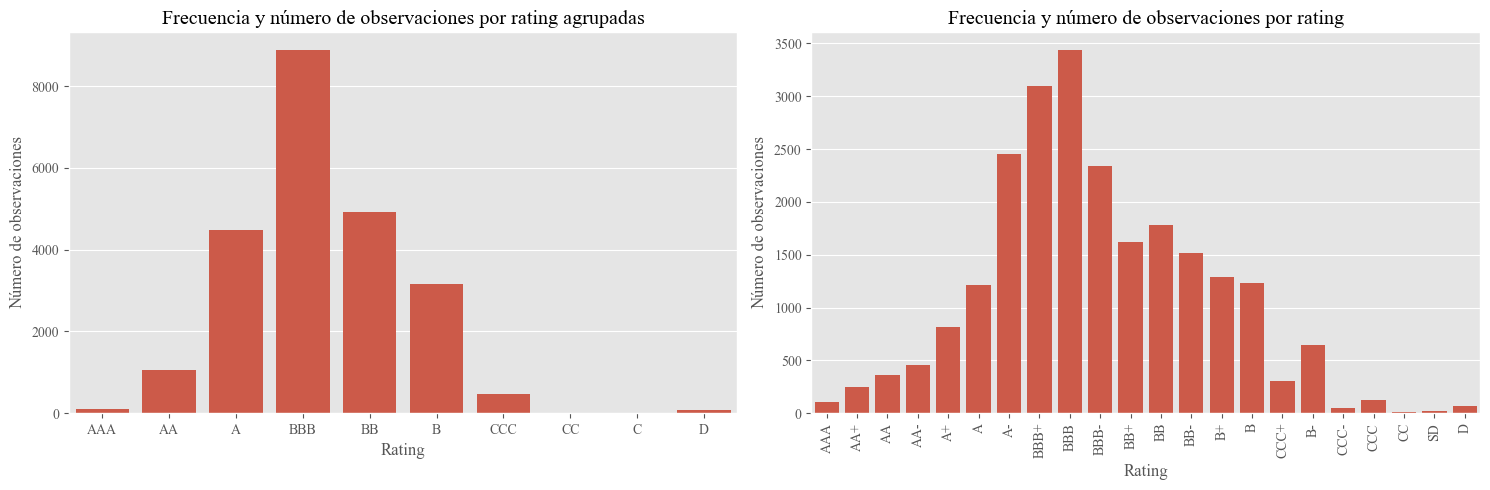

In [41]:
All_rating_order_group = {'AAA+':'AAA','AAA':'AAA','AAA-':'AAA',
                    'AA+':'AA','AA':'AA','AA-':'AA','A+':'A','A':'A','A-':'A',
                    'BBB+':'BBB','BBB':'BBB','BBB-':'BBB','BB+':'BB','BB':'BB','BB-':'BB','B+':'B','B':'B','B-':'B',
                    'CCC+':'CCC','CCC':'CCC','CCC-':'CCC','CC':'CC','C+':'C','C':'C','C-':'C','D':'D'}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de frecuencia y número de observaciones por rating agrupadas
sns.countplot(x='Rating_group', data=df, order=All_rating_order_group.values(), ax=axes[0])
axes[0].set_title('Frecuencia y número de observaciones por rating agrupadas')
axes[0].set_ylabel('Número de observaciones')
axes[0].set_xlabel('Rating')
axes[1].tick_params(axis='x', rotation=90) 
#axes[0].set_xticklabels(All_rating_order_group.values(), rotation=45)
#axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

# Gráfico de frecuencia y número de observaciones por rating agrupadas
sns.countplot(x='Rating', data=df, ax=axes[1])
axes[1].set_title('Frecuencia y número de observaciones por rating')
axes[1].set_ylabel('Número de observaciones')
axes[1].set_xlabel('Rating')
axes[1].tick_params(axis='x', rotation=90) 
#axes[1].set_xticklabels(All_rating_order_group.values(), rotation=45)
#axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(len(df)))

plt.tight_layout()
plt.show()

Ahora pasamos los datos categoricos a ordinales

In [42]:
df = df[df['Sector']!='0']
set(df['Sector'])

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

In [44]:
# Como la varaible Sector es categórica, se debe convertir a numérica
df['Sector_ordinal'] = df['Sector'].map({x:i for i,x in enumerate(set(df['Sector']))})

In [47]:
All_rating_order = ['AAA+','AAA','AAA-','AA+','AA','AA-','A+','A','A-','BBB+','BBB','BBB-','BB+','BB','BB-','B+','B','B-','CCC+','CCC','CCC-','CC','C+','C','C-','D','SD']
if len(set(df['Rating'])- set(All_rating_order)) == 0:
    print('Estan todas')
else:
    print('Faltan por clasificar')

Estan todas


In [48]:
# Hacemos los mismo para la variable Rating
df['Rating_ordinal'] = df['Rating'].map({x:i for i,x in enumerate(All_rating_order)})

In [52]:
set(All_rating_order_group.values())

{'A', 'AA', 'AAA', 'B', 'BB', 'BBB', 'C', 'CC', 'CCC', 'D'}

In [54]:
# Hacemos los mismo para la variable Rating_group
df['Rating_group_ordinal'] = df['Rating_group'].map({x:i for i,x in enumerate(rating_group_order)})

In [57]:
df[var_y+['Rating_ordinal','Rating_group','Rating_group_ordinal','Sector_ordinal']+var_x_num].head()

,Rating,Rating_ordinal,Rating_group,Rating_group_ordinal,Sector_ordinal,Net Debt to EBITDA,Debt to Assets,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt to Equity,Debt ratio,Financial Leverage
0,AAA,1,AAA,0.0,7,1.942794,0.449078,0.351596,0.319022,0.107467,0.383045,0.815138,3.182428,2.594117
1,AAA,1,AAA,0.0,7,15.000000,0.975040,1.602478,1.513781,0.136823,4.593871,5.753375,1.355706,14.886094
2,AAA,1,AAA,0.0,10,15.000000,0.999257,0.447961,0.426859,0.003048,4.593871,5.753375,1.176871,14.886094
3,AAA,1,AAA,0.0,7,3.084394,0.453090,0.285880,0.251404,0.018206,0.362835,0.828456,3.756757,3.112306
4,AAA,1,AAA,0.0,1,0.000000,0.197336,2.196962,1.271276,0.815073,0.180236,0.245851,7.287872,1.791730


In [60]:
stat, p = shapiro(df['Rating_group_ordinal'])

alpha = 0.05
if p > alpha:
    print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample looks Gaussian (fail to reject H0)")
else:
    print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample does not look Gaussian (reject H0)")

Varaiable: Financial Leverage             Statistics=nan, p=1.000 Sample looks Gaussian (fail to reject H0)


C:\Users\Ruben\AppData\Local\Temp\ipykernel_1600\4069962002.py:1: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23183.



Aunque no salga que es mormal en un historgrama se ver como una distribucion normal

La distribución Normal es una distribución continua de probabilidad. Es la distribución de probabilidad más utilizada debido a que es la que siguen muchas variables en la naturaleza y a que es la base de la inferencia estadística. Muchas pruebas estadísticas requieren como condición de aplicación que los datos no sean diferentes de una Normal. Por ello tienen gran importancia las pruebas de comprobación de normalidad. Existen pruebas gráficas y otras numéricas. Las más utilizadas son:

1) Representar los datos en papel probabilístico. Se trata de un gráfico de dispersión que compara los valores observados con los que esperaríamos encontrar si la distribución fuera Normal. Si los puntos siguen una recta diagonal los datos siguen una distribución Normal.
2) Representar un histograma y comprobar la forma de campana.
3) Comprobar que la distribución es simétrica y mesocúrtica. Se puede hacer comprobando que los coeficientes de asimetría (CA) y de apuntamiento o curtosis (CC) no son significativamente diferentes de 0 mediante sus intervalos de confianza del 95%, o bien comprobando que los coeficientes tipificados de asimetría y curtosis (cociente entre el coeficiente su error estándar) están comprendidos entre ±2.
4) Utilizar pruebas de bondad de ajuste como la prueba de Kolmogorov-Smirnov (K-S). Se basan en comparar la distribución acumulada de los valores de la muestra observada con la distribución acumulada que se obtendría en el supuesto que siguiera una distribución Normal con la misma media y varianza. Si en la prueba de K-S se obtienen valores de P<0,05 la distribución difiere significativamente de una Normal.


In [61]:
# Test de normalidad
for var in var_x_num:
    stat, p = shapiro(df[var])

    alpha = 0.05
    if p > alpha:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample does not look Gaussian (reject H0)")

C:\Users\Ruben\AppData\Local\Temp\ipykernel_11104\4290997659.py:3: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23183.



Varaiable: Net Debt to EBITDA             Statistics=0.836, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Debt to Assets                 Statistics=0.988, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Current Ratio                  Statistics=0.949, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Quick Ratio                    Statistics=0.974, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Cash ratio                     Statistics=0.910, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Long Term Debt to Equity       Statistics=0.763, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Debt to Equity                 Statistics=0.748, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Debt ratio                     Statistics=0.855, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable: Financial Leverage             Statistics=0.662, p=0.000 Sample does not look Gaussian (reject H0)
Varaiable:

DAdo que son muchos datos hacer otras pruebas, que si que soportan muchos datos

In [28]:
# Test de normalidad con lilliefors
for var in var_x_num:
    statistic, p_value = lilliefors(df[var])

    alpha = 0.05
    if p_value > alpha:
        print(f"Varaiable: {var: <30} Statistics={statistic:.3f}, p={p_value:.3f} Sample looks Gaussian (fail to reject H0)")
    else:
        print(f"Varaiable: {var: <30} Statistics={statistic:.3f}, p={p_value:.3f} Sample does not look Gaussian (reject H0)")

Varaiable: Net Debt to EBITDA             Statistics=0.136, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Debt to Assets                 Statistics=0.031, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Current Ratio                  Statistics=0.070, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Quick Ratio                    Statistics=0.052, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Cash ratio                     Statistics=0.118, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Long Term Debt to Equity       Statistics=0.195, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Debt to Equity                 Statistics=0.199, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Debt ratio                     Statistics=0.131, p=0.001 Sample does not look Gaussian (reject H0)
Varaiable: Financial Leverage             Statistics=0.225, p=0.001 Sample does not look Gaussian (reject H0)


In [34]:
# Test de Normalidad de anderson para todas las variables
for var in var_x_num:
    result = anderson(df[var])
    #print(f'Anderson-Darling test statistic: {result.statistic}')
    #solo mostrando el nivel de significancia del 1%
    sl, cv = result.significance_level[-1], result.critical_values[-1]
    if result.statistic < cv:
        print(f'Probablemente normal a nivel de significancia {sl}%')
    else:
        print(f'Probablemente no normal a nivel de significancia {sl}%')

Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%
Probablemente no normal a nivel de significancia 1.0%


In [25]:
# Test de homogenidad de varianzas (homocedasticidad)
for var in var_x_num:
    group_data = {group: df[var][df['Rating'] == group] for group in df['Rating'].unique()}
    stat, p = levene(*group_data.values())
    alpha = 0.05
    if p > alpha:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f}'Sample looks homoscedastic (fail to reject H0)")
    else:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} SSample does not look homoscedastic (reject H0)")
    


Varaiable: Net Debt to EBITDA             Statistics=36.364, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Debt to Assets                 Statistics=30.172, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Current Ratio                  Statistics=9.271, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Quick Ratio                    Statistics=7.451, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Cash ratio                     Statistics=4.535, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Long Term Debt to Equity       Statistics=66.049, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Debt to Equity                 Statistics=57.453, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Debt ratio                     Statistics=35.989, p=0.000 SSample does not look homoscedastic (reject H0)
Varaiable: Financial Leverage             Statistics=37.633, p=0.00

Dado que no hay homoceoastiadad, asjutamos los datos y lo volvemos a comprobar

Otro punt importante es ver so hay autocorrelacion entre las varables, primero vemos la matriz de correlacion.

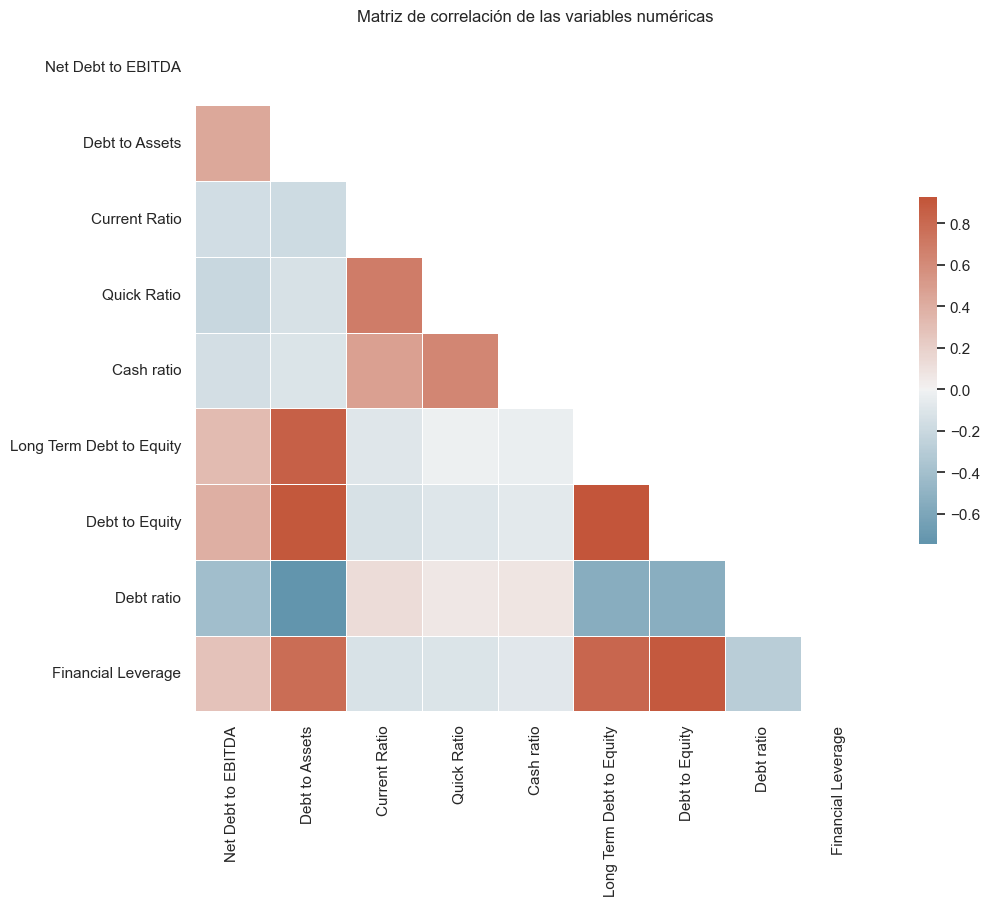

In [66]:
# plot in seabron a matrix correlation with the var_x_num for the df
corr = df[var_x_num].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# delte the grid line

sns.set(style="whitegrid")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.grid(False)
plt.title('Matriz de correlación de las variables numéricas')
plt.show()


Y ahora vemos cuales son significas

In [84]:
# hacer una lista con los datos de var_x_num sin el elemeto 'Debt to Assets'
var_x_num_ = [x for x in var_x_num if x != 'Debt to Assets' and x != 'Debt to Equity'] + ['Sector_ordinal']

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df[var_x_num_])

# Calcular VIF para cada variable predictora
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

,VIF Factor,features
0,21.696221,const
1,1.300994,Net Debt to EBITDA
2,1.931336,Current Ratio
3,2.527317,Quick Ratio
4,1.674740,Cash ratio
5,4.429774,Long Term Debt to Equity
6,1.785476,Debt ratio
7,3.557377,Financial Leverage
8,1.077741,Sector_ordinal


La función variance_inflation_factor calcula el Factor de Inflación de la Varianza para cada variable predictora en un modelo de regresión. El VIF mide cuánto se infla la varianza de un estimador de coeficiente específico debido a la colinealidad existente entre las variables predictoras en el modelo. En esencia, el VIF evalúa si la variabilidad de una variable predictora puede ser explicada por otras variables predictoras en el modelo.

XXX pensar y ver si quitamos estas variables 

 Así en función de la independencia, normalidad de los datos y el tamaño de muestra caben 4 posibilidades:

·        Datos independientes que siguen una distribución Normal o el tamaño de ambas muestras >=30. Se utiliza la prueba T de Student para datos independientes. Previamente se debe realizar una comparación de varianzas mediante el contraste de hipótesis adecuado (ver apartado de comparación de varianzas) puesto que las fórmulas cambian ligeramente en caso de que las varianzas sean iguales o diferentes. La mayor parte de los programas estadísticos realizan esta comparación de varianzas automáticamente.

·        Datos independientes que no siguen una distribución Normal y el tamaño de las muestras <30. No puede utilizarse la prueba T de Student y se deben usar pruebas no paramétricas. Las pruebas no paramétricas se basan, como la mediana, en comparar las posiciones de los valores, no los valores en sí mismos y siempre suponen una mayor o menor pérdida de información. En el caso de datos independientes (no apareados) se utiliza la prueba U de Mann-Whitney.

·        Datos apareados que siguen una distribución Normal o el tamaño de ambas muestras >=30. Se utiliza la prueba T de Student para datos apareados. En realidad cuando los datos son apareados se trabaja con las medias de las diferencias entre los 2 valores de cada elemento (en la comparación de medias independientes usábamos la diferencia de las medias de los 2 grupos). La potencia del análisis en los diseños apareados es mayor.

·        Datos apareados que no siguen una distribución Normal y tamaño de muestra <30. Deben utilizarse pruebas no paramétricas, en este caso la prueba T de Wilcoxon.

Ya hemos visto que no son normales y no tienen varianzas homogéneas. Por tanto debemos considerar el uso de métodos no paramétricos para tus análisis, como la prueba de Kruskal-Wallis para comparar medianas en lugar de medias. 

In [38]:
# Aplicamos la prueba de Kruskal-Wallis para ver si las mediandas de las variables numéricas son iguales para cada grupo de Rating
for var in var_x_num:
    group_data = {group: df[var][df['Rating'] == group] for group in df['Rating'].unique()}
    stat, p = kruskal(*group_data.values())
    alpha = 0.05
    if p > alpha:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample looks the same (fail to reject H0)")
    else:
        print(f"Varaiable: {var: <30} Statistics={stat:.3f}, p={p:.3f} Sample does not look the same (reject H0)")

Varaiable: Net Debt to EBITDA             Statistics=1107.501, p=0.000 Sample does not look the same (reject H0)
Varaiable: Debt to Assets                 Statistics=1740.250, p=0.000 Sample does not look the same (reject H0)
Varaiable: Current Ratio                  Statistics=1090.388, p=0.000 Sample does not look the same (reject H0)
Varaiable: Quick Ratio                    Statistics=994.844, p=0.000 Sample does not look the same (reject H0)
Varaiable: Cash ratio                     Statistics=1006.198, p=0.000 Sample does not look the same (reject H0)
Varaiable: Long Term Debt to Equity       Statistics=1838.094, p=0.000 Sample does not look the same (reject H0)
Varaiable: Debt to Equity                 Statistics=1744.803, p=0.000 Sample does not look the same (reject H0)
Varaiable: Debt ratio                     Statistics=1728.064, p=0.000 Sample does not look the same (reject H0)
Varaiable: Financial Leverage             Statistics=1195.754, p=0.000 Sample does not look the s

Si el p-valor es menor que tu nivel de significancia (comúnmente 0.05), puedes concluir que hay diferencias estadísticamente significativas entre al menos dos de los grupos. Sin embargo, la prueba no te dice cuáles grupos son diferentes entre sí. Para determinar esto, necesitarías realizar análisis post-hoc, como pruebas de comparaciones múltiples o la prueba de Dunn, para identificar específicamente entre qué grupos existen las diferencias.

Una vez que has determinado que existen diferencias significativas entre los grupos mediante la prueba de Kruskal-Wallis, el siguiente paso es realizar un análisis post-hoc para identificar específicamente entre qué pares de grupos existen esas diferencias. La Prueba de Dunn es una opción popular para comparaciones múltiples después de una Prueba de Kruskal-Wallis, ya que es diseñada para datos no paramétricos.

Varaiable: Net Debt to EBITDA             Statistics=1108, p=0.00 Sample does not look the same (reject H0)
Varaiable: Debt to Assets                 Statistics=1740, p=0.00 Sample does not look the same (reject H0)
Varaiable: Current Ratio                  Statistics=1090, p=0.00 Sample does not look the same (reject H0)
Varaiable: Quick Ratio                    Statistics=995, p=0.00 Sample does not look the same (reject H0)
Varaiable: Cash ratio                     Statistics=1006, p=0.00 Sample does not look the same (reject H0)
Varaiable: Long Term Debt to Equity       Statistics=1838, p=0.00 Sample does not look the same (reject H0)
Varaiable: Debt to Equity                 Statistics=1745, p=0.00 Sample does not look the same (reject H0)
Varaiable: Debt ratio                     Statistics=1728, p=0.00 Sample does not look the same (reject H0)
Varaiable: Financial Leverage             Statistics=1196, p=0.00 Sample does not look the same (reject H0)


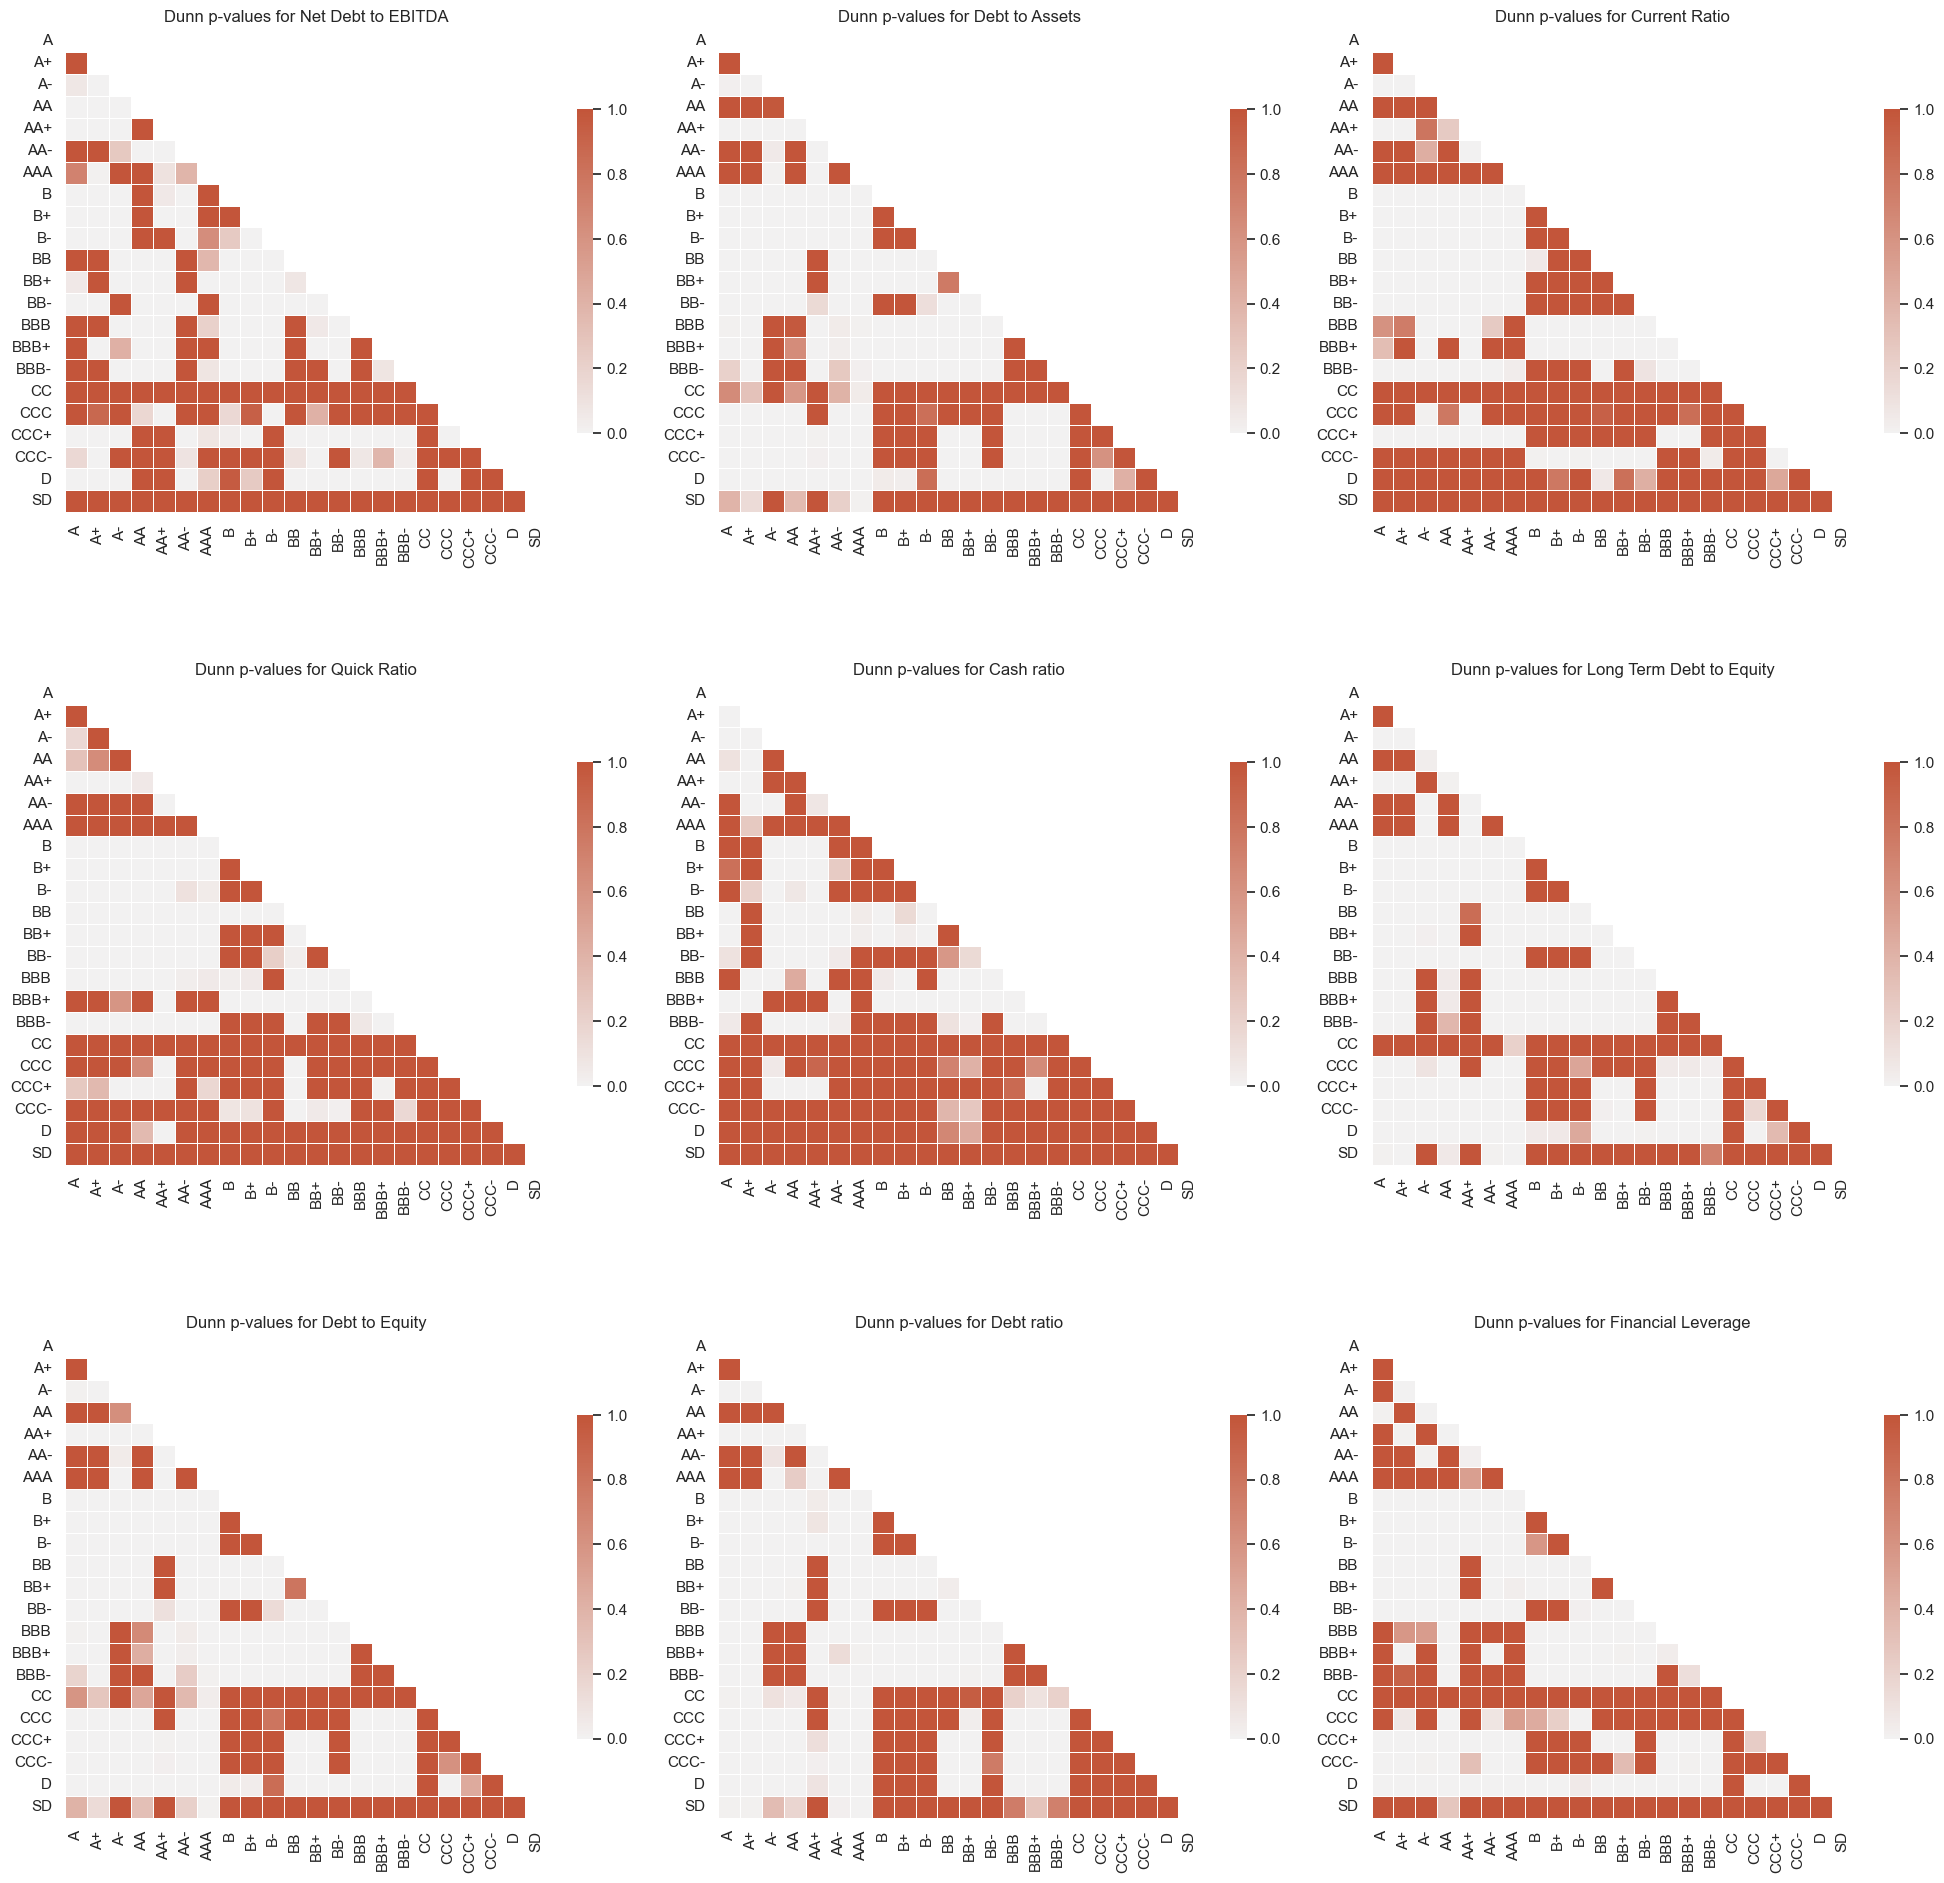

In [50]:
import scikit_posthocs as sp

# Realizar la prueba de Kruskal-Wallis primero para verificar si hay diferencias globales para cada variable numérica
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.set_theme(style="white")

for i, var in enumerate(var_x_num):
    group_data = {group: df[var][df['Rating'] == group] for group in df['Rating'].unique()}
    stat, p = kruskal(*group_data.values())
    alpha = 0.05
    if p > alpha:
        print(f"Varaiable: {var: <30} Statistics={stat:.0f}, p={p:.2f} Sample looks the same (fail to reject H0)")
    else:
        print(f"Varaiable: {var: <30} Statistics={stat:.0f}, p={p:.2f} Sample does not look the same (reject H0)")

    # Si hay diferencias globales, aplicar la prueba de Dunn para identificar las diferencias entre los grupos
    if p <= alpha:
        #  En este caso, se utiliza el ajuste de Bonferroni para corregir el problema de realizar múltiples comparaciones, lo cual es importante para mantener el nivel de error Tipo I bajo control.
        dunn_vals = sp.posthoc_dunn(df, val_col=var, group_col='Rating', p_adjust='bonferroni')
        
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(dunn_vals, dtype=bool))
        # Generate a custom diverging colormap
        #cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
        # plot the p-values matrix for Dunn's test
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        # delete the grid lines
        ax.grid(False)
        sns.heatmap(dunn_vals,ax=ax, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
        ax.set_title(f'Dunn p-values for {var}')

plt.tight_layout()
plt.show()


Esto nos dice que para los cudrantes donde el p-value es proximoa 0 (es decir blranco) las medias de las muestras son diferentes. 

Es decir el LT debt to equity y el Debt ratiosson uno de los mejoreas predictores (potencailemte ) porque las muestras de estas dos metricas para diferetnetss ratings, tiene medias diferntes con un alto grado de probabilidad.

Ajuste de Bonferroni

Al realizar múltiples comparaciones, el riesgo de cometer al menos un error de Tipo I (falso positivo) aumenta. El ajuste de Bonferroni es una manera conservadora de corregir este problema, dividiendo el nivel de significancia deseado (αα, generalmente 0.05) por el número total de comparaciones. Esto resulta en un umbral más estricto para determinar la significancia estadística, lo cual reduce la tasa de falsos positivos a costa de ser menos sensible a las diferencias reales (aumenta el riesgo de errores de Tipo II, o falsos negativos).

In [88]:
# select only 1000 rows for the plot
df_sample = df[var_x_num_+['Rating_group']].sample(1000, random_state=1)

In [89]:
df_sample.head()

,Net Debt to EBITDA,Current Ratio,Quick Ratio,Cash ratio,Long Term Debt to Equity,Debt ratio,Financial Leverage,Sector_ordinal,Rating_group
22922,3.388412,1.000860,0.834692,0.399512,0.417972,3.896573,1.878896,4,A
18353,3.528526,2.194237,1.324724,0.735593,1.323243,2.025486,2.773643,7,BB
20586,2.235200,0.221320,0.114961,0.102397,0.000000,2.045108,9.956665,6,BBB
16781,1.290904,2.182854,0.585475,0.320887,0.288095,5.024591,1.662192,2,A
875,0.739036,1.354468,1.033617,0.405532,0.273274,6.337995,1.741503,2,BBB


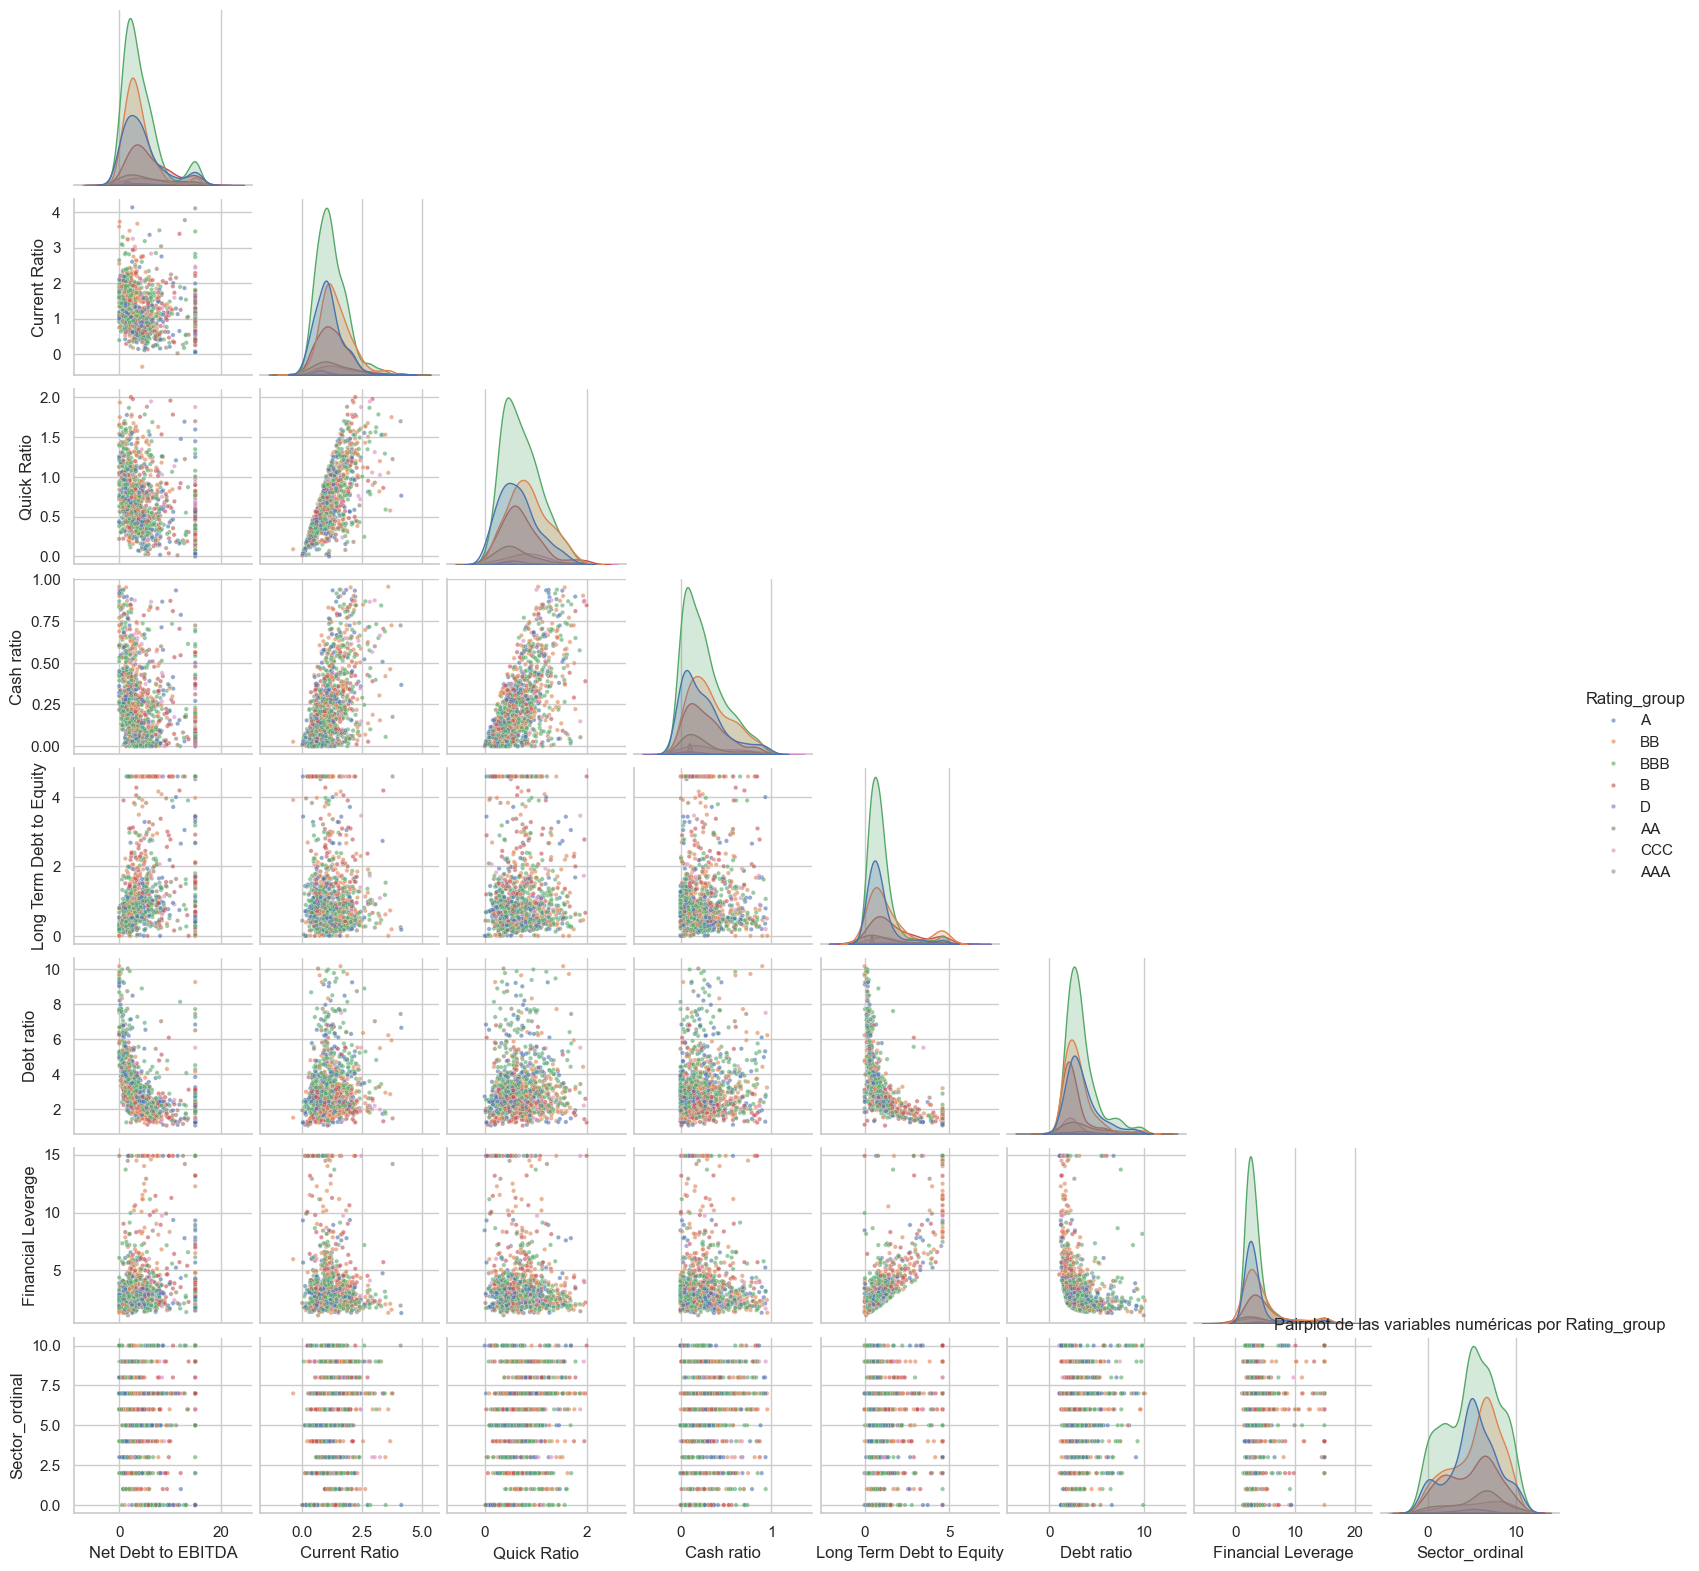

In [92]:
# make a seaborn pairplot by rating_group
pairplot = sns.pairplot(df_sample, hue='Rating_group', plot_kws={'alpha': 0.6, 's': 10}, corner=True,height=2)
plt.title('Pairplot de las variables numéricas por Rating_group')
plt.show()

Por ahora vamos a meter todas las variables pero parece que hay algunas que no van a funcionar, pero puede que al meter el sector mejoren. Por tanto ahora veamos que pasa por indústria.